In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("cleaned_dataset.csv")

# Drop unnecessary columns
df = df.drop(columns=["price_per_km", "price_per_horsepower", "insertion_date","title"])

# Move 'price' to the last column
price_col = df.pop("price")
df["price"] = price_col
df = df[(df['age'] >= 0) & (df['age'] <= 100)]

# One-hot encoding for categorical features
categorical_features = ['manufacturer', 'category', 'fuel_type', 'transmission']
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(df[categorical_features])

# Convert encoded features to DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Combine encoded features with numerical features
numerical_features = ['fiscal_horsepower', 'mileage', 'age']
X = pd.concat([df[numerical_features].reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Target variable
y = df['price']

# Feature selection (Mutual Information)
from sklearn.feature_selection import mutual_info_regression
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
important_features = mi_scores[mi_scores > 0.01].index
X_selected = X[important_features]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluation
y_pred_rf = rf.predict(X_test)
print("Random Forest Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2 Score:", r2_score(y_test, y_pred_rf))

# Function to map user input
def get_user_input():
    """Get user input for car details."""
    user_input = {}
    # Manufacturer input
    manufacturers = [
        "Land Rover", "Porsche", "Jaguar", "Cupra", "Isuzu",
        "Mercedes", "Jeep", "BMW", "Toyota", "Other"
    ]
    print("Manufacturers: ")
    for i, manu in enumerate(manufacturers, 1):
        print(f"{i} - {manu}")
    manufacturer_choice = int(input(f"Select manufacturer (1-{len(manufacturers)}): "))
    manufacturer_mapping = {manu: f"manufacturer_{manu}" for manu in manufacturers}
    selected_manufacturer = manufacturers[manufacturer_choice - 1]
    user_input[manufacturer_mapping[selected_manufacturer]] = 1

    # Initialize one-hot encoded columns to 0 for all manufacturers
    for manu in manufacturers:
        if manu != selected_manufacturer:
            user_input[manufacturer_mapping[manu]] = 0

    user_input['fiscal_horsepower'] = float(input("Enter fiscal horsepower: "))
    user_input['mileage'] = float(input("Enter mileage: "))
    user_input['age'] = float(input("Enter age: "))

    # Fuel type input
    print("Fuel types: 1 - Petrol, 2 - Diesel, 3 - Hybrid Petrol, 4 - Hybrid Diesel, 5 - Electric")
    fuel_type = int(input("Select fuel type (1-5): "))
    fuel_mapping = {
        1: 'fuel_type_Petrol',
        2: 'fuel_type_Diesel',
        3: 'fuel_type_Hybrid Petrol',
        4: 'fuel_type_Hybrid Diesel',
        5: 'fuel_type_Electric'
    }
    # Initialize fuel type one-hot columns to 0 and set the chosen one to 1
    for fuel in fuel_mapping.values():
        user_input[fuel] = 0
    user_input[fuel_mapping[fuel_type]] = 1

    # Transmission input
    print("Transmission: 1 - Automatic, 2 - Manual")
    transmission = int(input("Select transmission (1-2): "))
    user_input['transmission_Manual'] = 1 if transmission == 2 else 0

    return user_input

# Predict price
def predict_price(model, user_input, encoder, scaler, features, default_values):
    """
    Predict car price using a trained model.
    Args:
        model: Trained model.
        user_input: Dictionary of user-provided feature values.
        encoder: OneHotEncoder used for categorical features.
        scaler: StandardScaler used for numerical features.
        features: List of important features.
        default_values: Default values for missing features.
    Returns:
        Predicted price.
    """
    # Fill missing values in user_input
    for feature in features:
        if feature not in user_input:
            user_input[feature] = default_values.get(feature, 0)

    # Convert to DataFrame
    input_df = pd.DataFrame([user_input])
    input_scaled = scaler.transform(input_df[features])

    # Predict and return the result
    return model.predict(input_scaled)[0]

# Prepare default values for missing inputs
default_values = {
    'fiscal_horsepower': df['fiscal_horsepower'].median(),
    'mileage': df['mileage'].median(),
    'age': df['age'].median(),
}
for column in encoder.get_feature_names_out(categorical_features):
    default_values[column] = 0  # Default value for one-hot encoded features

# User input
user_input = get_user_input()

# Predict price
predicted_price = predict_price(rf, user_input, encoder, scaler, important_features, default_values)
print(f"Predicted car price: TND{predicted_price:.2f}")


Random Forest Performance:
MAE: 18932.10774551132
RMSE: 30390.3208256491
R2 Score: 0.7991589946196495
Manufacturers: 
1 - Land Rover
2 - Porsche
3 - Jaguar
4 - Cupra
5 - Isuzu
6 - Mercedes
7 - Jeep
8 - BMW
9 - Toyota
10 - Other
Select manufacturer (1-10): 9
Enter fiscal horsepower: 7
Enter mileage: 100000
Enter age: 5
Fuel types: 1 - Petrol, 2 - Diesel, 3 - Hybrid Petrol, 4 - Hybrid Diesel, 5 - Electric
Select fuel type (1-5): 1
Transmission: 1 - Automatic, 2 - Manual
Select transmission (1-2): 2
Predicted car price: TND64739.00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv("cleaned_dataset.csv")


# Drop unnecessary columns
df = df.drop(columns=["price_per_km", "price_per_horsepower", "insertion_date","year"])

# Move 'price' to the last column
price_col = df.pop("price")
df["price"] = price_col

# Display the updated DataFrame
print(df.head())

print(df.info())          # Check data types and missing values
print(df.describe())      # Summary statistics for numerical columns



                         title manufacturer category fuel_type  \
0                      Audi S3         Audi     City    Petrol   
1  Mahindra Scorpio Pick-up DC     Mahindra   Pickup    Diesel   
2                   Fiat Doblo         Fiat  Minivan    Petrol   
3                  Ford Fusion         Ford    Sedan    Petrol   
4                MG GS AWD 2.0           MG      SUV    Petrol   

   fiscal_horsepower transmission   mileage  age     price  
0               19.0    Automatic  120000.0   10  128000.0  
1                7.0       Manual   85000.0    4   32000.0  
2                6.0       Manual   32000.0    3   56000.0  
3                9.0       Manual  200000.0    9   45000.0  
4               13.0    Automatic  100000.0    7   61000.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1578 entries, 0 to 1577
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1578 non-nu

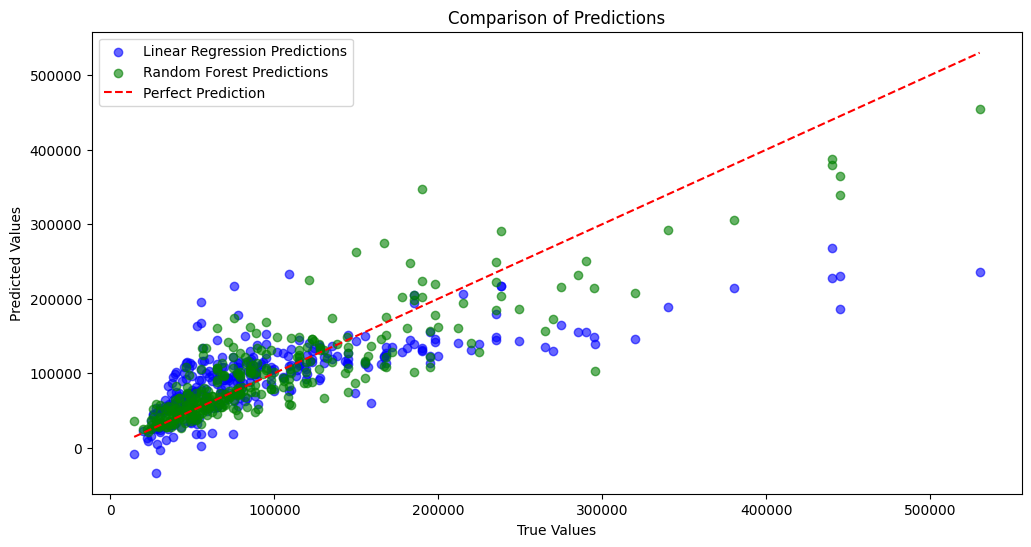

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot for comparison
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_lr, color='blue', label='Linear Regression Predictions', alpha=0.6)
plt.scatter(y_test, y_pred_rf, color='green', label='Random Forest Predictions', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Comparison of Predictions')
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv("cleaned_dataset.csv")


# Drop unnecessary columns
df = df.drop(columns=["price_per_km", "price_per_horsepower", "insertion_date","year"])

# Move 'price' to the last column
price_col = df.pop("price")
df["price"] = price_col

# Display the updated DataFrame
print(df.head())

print(df.info())          # Check data types and missing values
print(df.describe())      # Summary statistics for numerical columns


                         title manufacturer category fuel_type  \
0                      Audi S3         Audi     City    Petrol   
1  Mahindra Scorpio Pick-up DC     Mahindra   Pickup    Diesel   
2                   Fiat Doblo         Fiat  Minivan    Petrol   
3                  Ford Fusion         Ford    Sedan    Petrol   
4                MG GS AWD 2.0           MG      SUV    Petrol   

   fiscal_horsepower transmission   mileage  age     price  
0               19.0    Automatic  120000.0   10  128000.0  
1                7.0       Manual   85000.0    4   32000.0  
2                6.0       Manual   32000.0    3   56000.0  
3                9.0       Manual  200000.0    9   45000.0  
4               13.0    Automatic  100000.0    7   61000.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1578 entries, 0 to 1577
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1578 non-nu

In [ ]:
numerical_columns = df.select_dtypes(include=["float64", "int64"]).columns


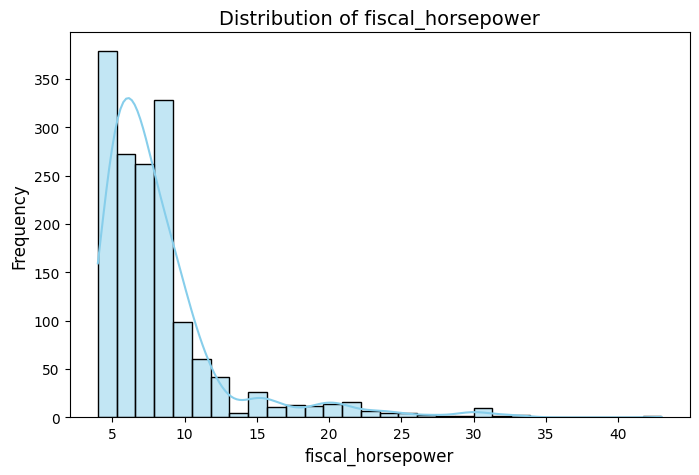

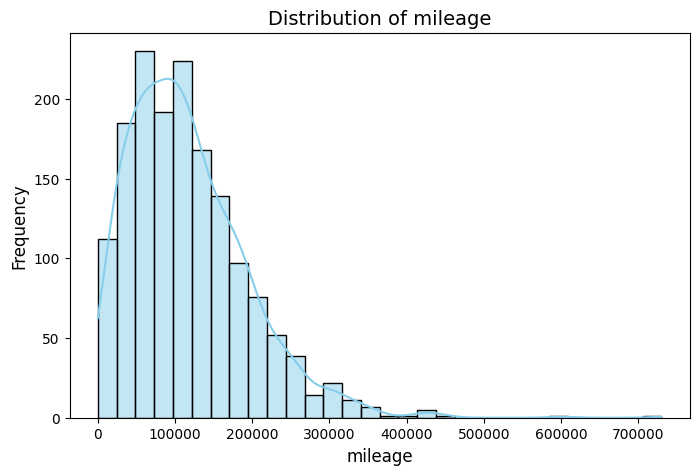

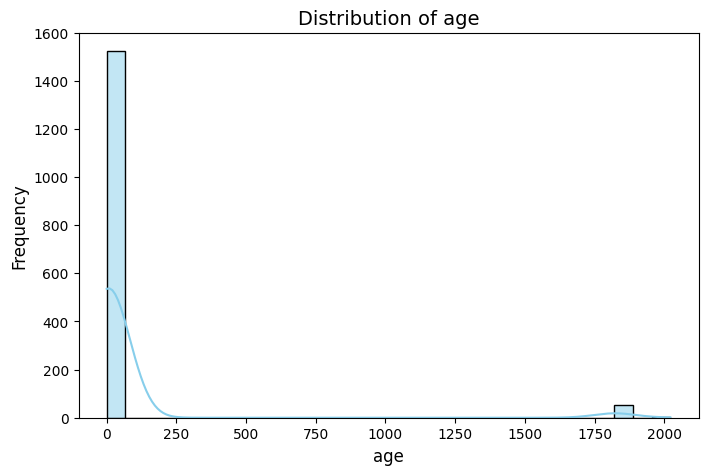

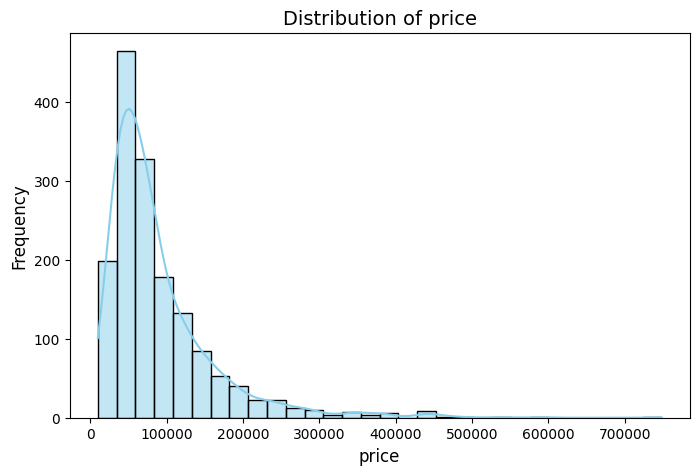

In [ ]:
import seaborn as sns
for col in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col], bins=30, kde=True, color='skyblue')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.show()

In [ ]:
df = df[(df['age'] >= 0) & (df['age'] <= 100)]

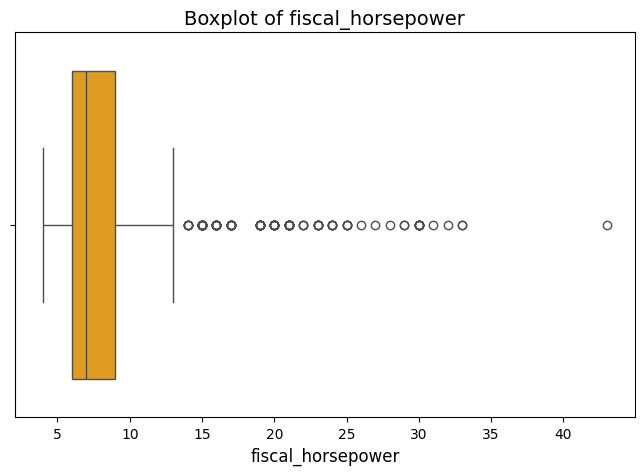

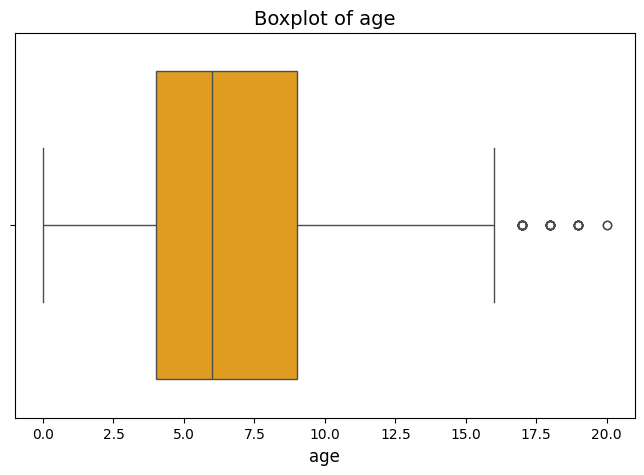

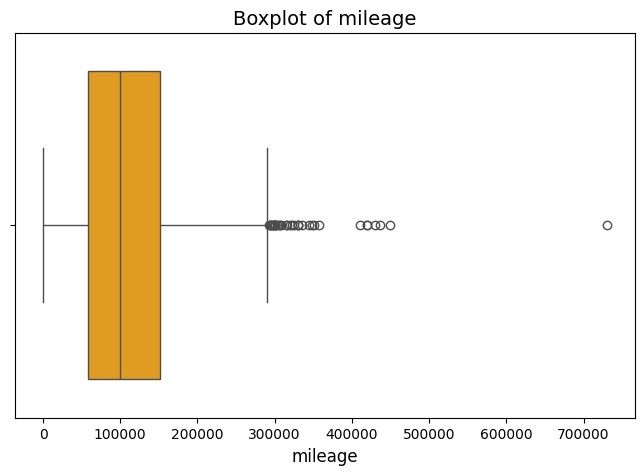

In [ ]:
for col in numerical_columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[col], color='orange')
    plt.title(f'Boxplot of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.show()

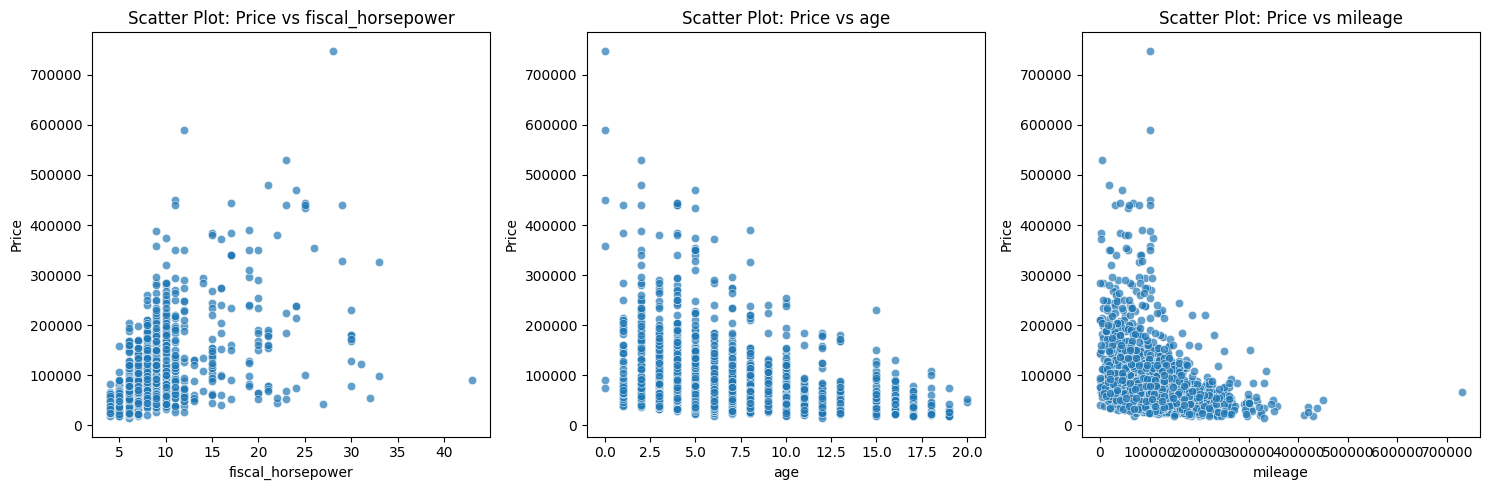

In [ ]:
# List of numerical variables to compare with `price`
numerical_columns = ['fiscal_horsepower', 'age', 'mileage']

# Create scatter plots for each variable against `price`
plt.figure(figsize=(15, 5))

for i, column in enumerate(numerical_columns):
    plt.subplot(1, len(numerical_columns), i + 1)
    sns.scatterplot(data=df, x=column, y='price', alpha=0.7)
    plt.title(f'Scatter Plot: Price vs {column}')
    plt.xlabel(column)
    plt.ylabel('Price')

plt.tight_layout()
plt.show()

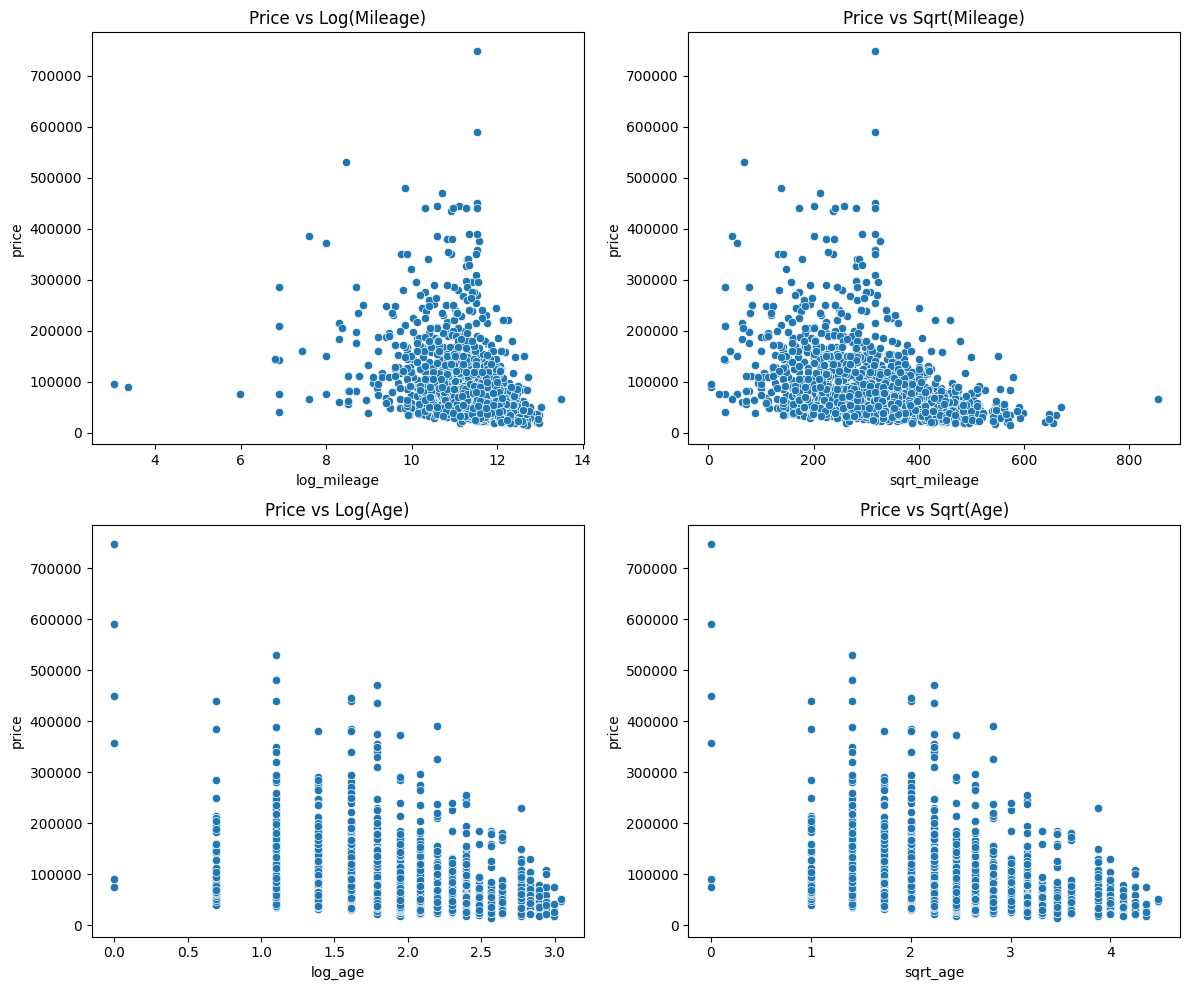

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply transformations to the mileage and age columns
df['log_mileage'] = np.log1p(df['mileage'])  # Log transformation (log1p handles log(0) by adding 1)
df['sqrt_mileage'] = np.sqrt(df['mileage'])  # Square root transformation

df['log_age'] = np.log1p(df['age'])  # Log transformation for age
df['sqrt_age'] = np.sqrt(df['age'])  # Square root transformation

# Scatter plots after transformation
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Price vs log_mileage
sns.scatterplot(x='log_mileage', y='price', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Price vs Log(Mileage)')

# Price vs sqrt_mileage
sns.scatterplot(x='sqrt_mileage', y='price', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Price vs Sqrt(Mileage)')

# Price vs log_age
sns.scatterplot(x='log_age', y='price', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Price vs Log(Age)')

# Price vs sqrt_age
sns.scatterplot(x='sqrt_age', y='price', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Price vs Sqrt(Age)')

# Adjust layout
plt.tight_layout()
plt.show()


<ipython-input-20-7b1dfa522a15>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=column, y=target, data=data, palette='Set2')


<Figure size 1600x1000 with 0 Axes>

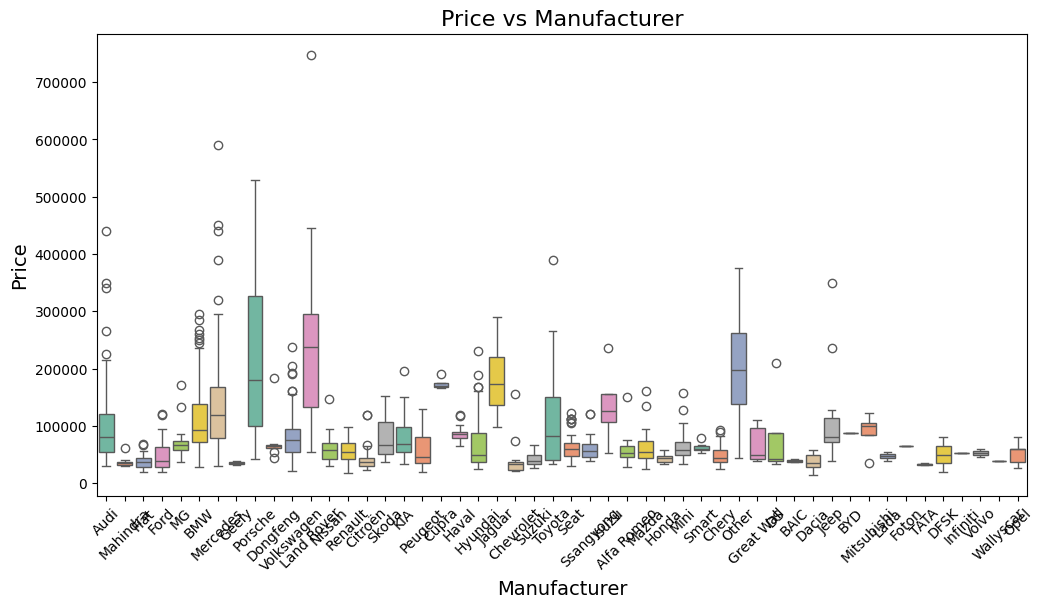

<ipython-input-20-7b1dfa522a15>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=column, y=target, data=data, palette='Set2')


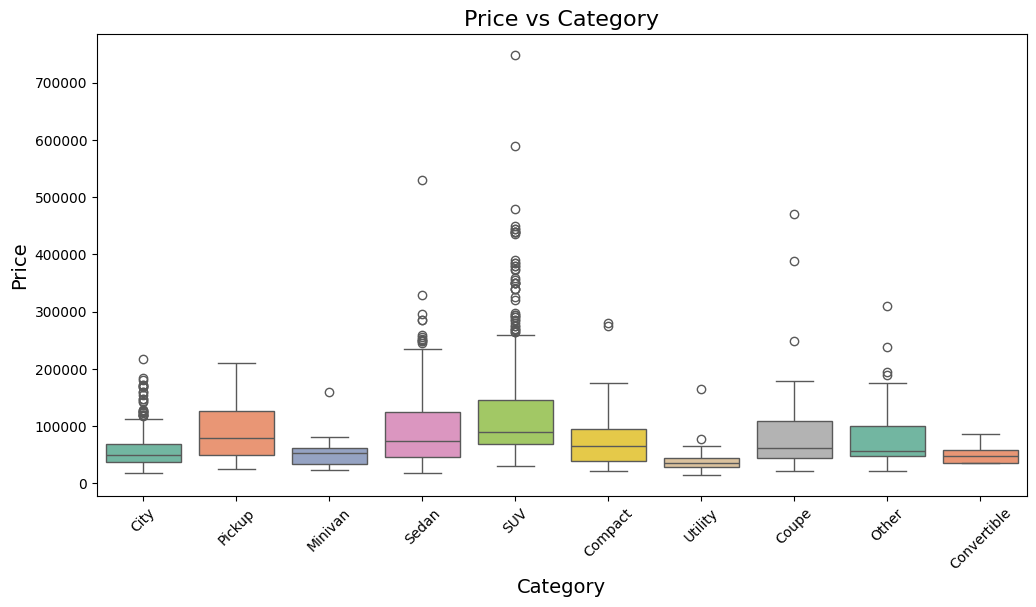

<ipython-input-20-7b1dfa522a15>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=column, y=target, data=data, palette='Set2')


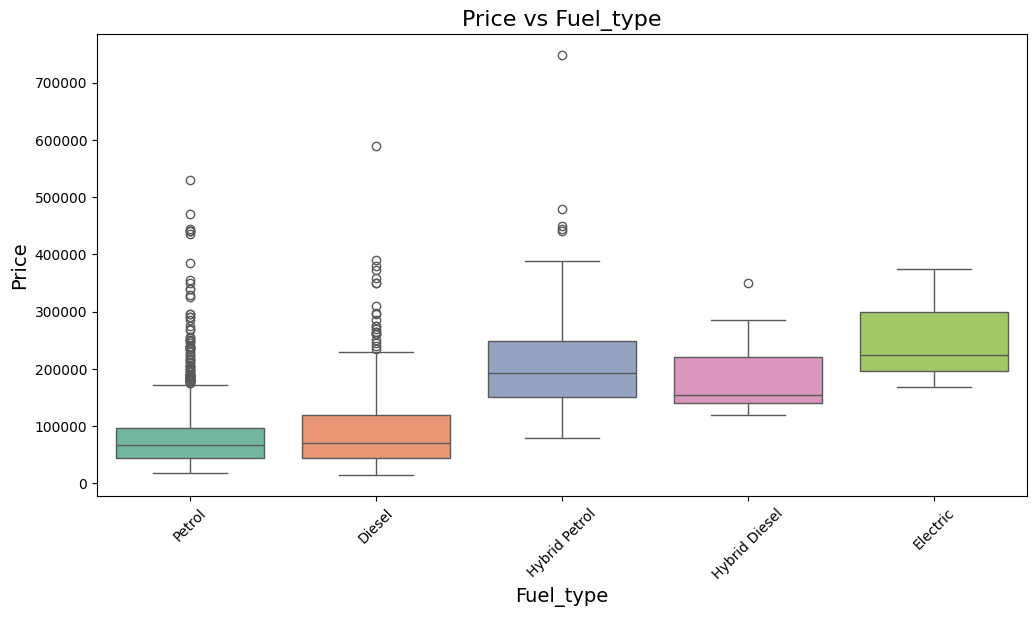

<ipython-input-20-7b1dfa522a15>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=column, y=target, data=data, palette='Set2')


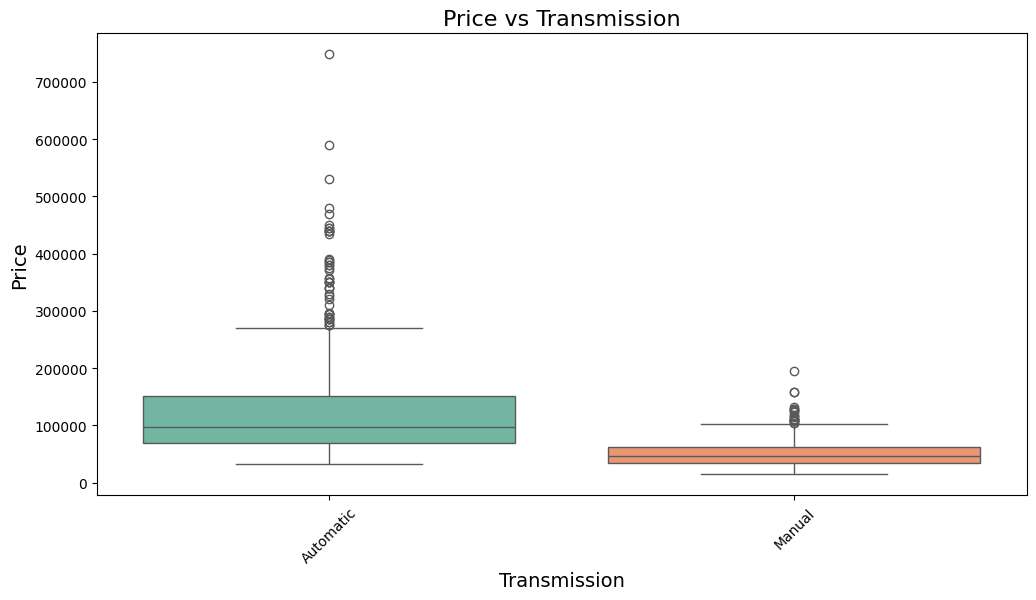

<ipython-input-20-7b1dfa522a15>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='coolwarm', order=df[col].value_counts().index)


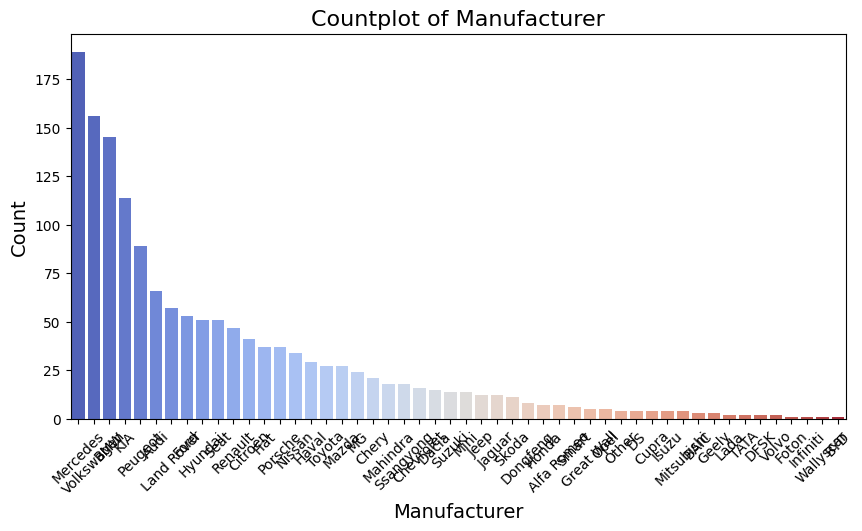

<ipython-input-20-7b1dfa522a15>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='coolwarm', order=df[col].value_counts().index)


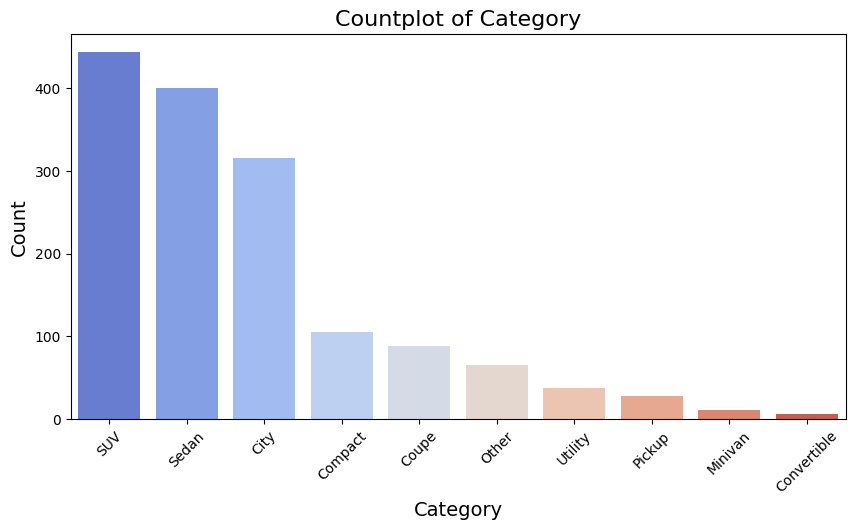

<ipython-input-20-7b1dfa522a15>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='coolwarm', order=df[col].value_counts().index)


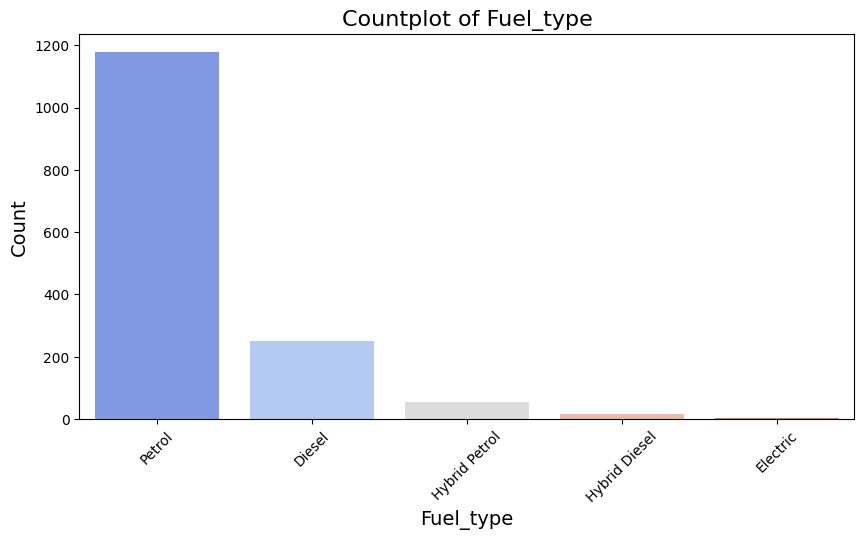

<ipython-input-20-7b1dfa522a15>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette='coolwarm', order=df[col].value_counts().index)


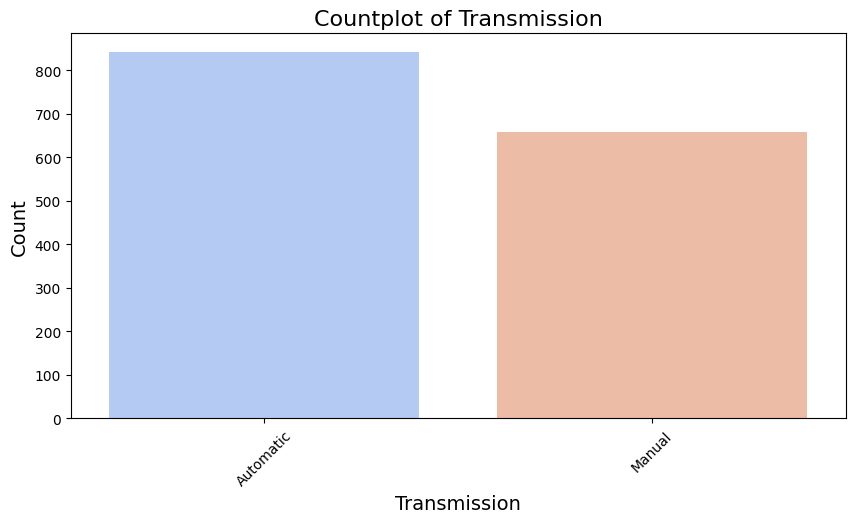

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a larger figure size for better visuals
plt.figure(figsize=(16, 10))

# Function to create bar plots for categorical features
def plot_categorical_vs_price(data, column, target='price'):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=column, y=target, data=data, palette='Set2')
    plt.title(f'{target.capitalize()} vs {column.capitalize()}', fontsize=16)
    plt.xticks(rotation=45)
    plt.xlabel(column.capitalize(), fontsize=14)
    plt.ylabel(target.capitalize(), fontsize=14)
    plt.show()

# Analyze 'manufacturer'
plot_categorical_vs_price(df, 'manufacturer')

# Analyze 'category'
plot_categorical_vs_price(df, 'category')

# Analyze 'fuel_type'
plot_categorical_vs_price(df, 'fuel_type')

# Analyze 'transmission'
plot_categorical_vs_price(df, 'transmission')

# Countplot for categorical variables
categorical_columns = ['manufacturer', 'category', 'fuel_type', 'transmission']
for col in categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, data=df, palette='coolwarm', order=df[col].value_counts().index)
    plt.title(f'Countplot of {col.capitalize()}', fontsize=16)
    plt.xlabel(col.capitalize(), fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

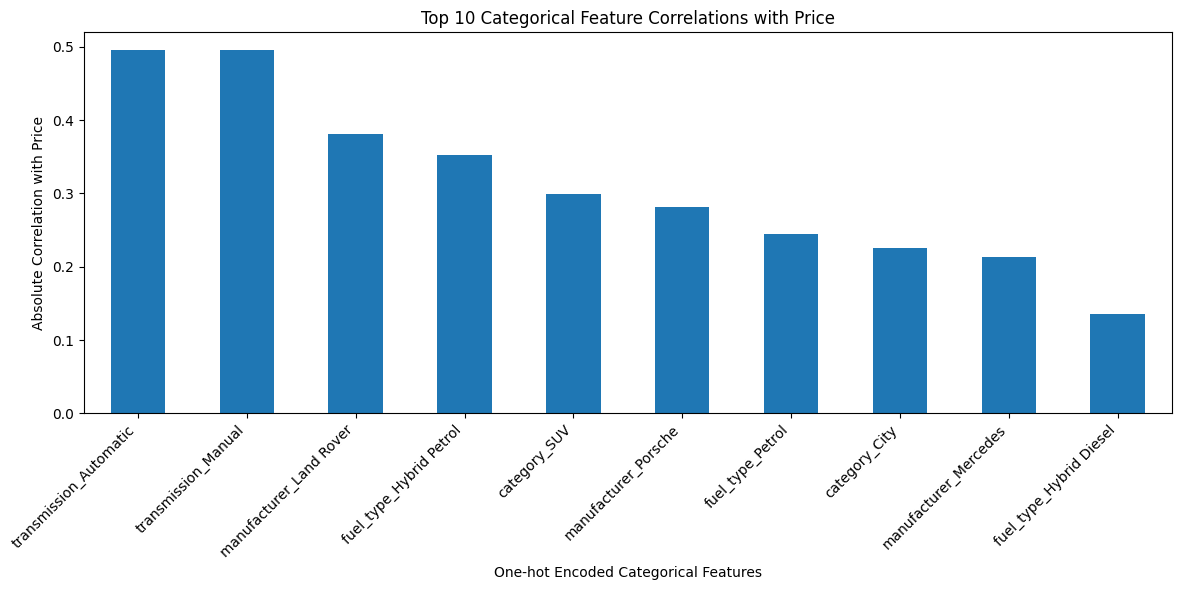

In [ ]:
plt.figure(figsize=(12, 6))

    # One-hot encode categorical variables
categorical_features = ['manufacturer', 'category', 'fuel_type', 'transmission']
encoded_df = pd.get_dummies(df[categorical_features + ['price']])

# Calculate correlation of one-hot encoded features with price
price_correlations = encoded_df.corr()['price'].abs().sort_values(ascending=False)
top_correlations = price_correlations[1:11]  # Exclude price itself
top_correlations.plot(kind='bar')
plt.title('Top 10 Categorical Feature Correlations with Price')
plt.xlabel('One-hot Encoded Categorical Features')
plt.ylabel('Absolute Correlation with Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Mutual Information Scores:
fiscal_horsepower      0.377570
transmission_Manual    0.267011
mileage                0.133439
age                    0.116423
category_SUV           0.094491
                         ...   
manufacturer_Audi      0.000000
manufacturer_Geely     0.000000
manufacturer_DS        0.000000
manufacturer_DFSK      0.000000
manufacturer_Mini      0.000000
Length: 66, dtype: float64


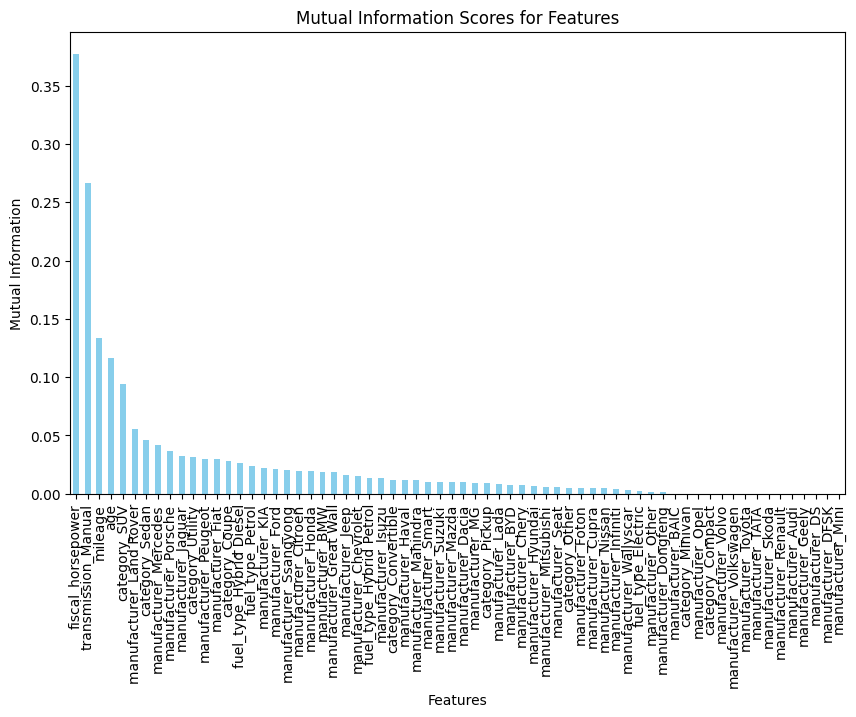

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import numpy as np

# Assume df is your DataFrame
# Categorical features
categorical_features = ['manufacturer', 'category', 'fuel_type', 'transmission']

# One-hot encoding for categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)  # Set sparse=False to get a dense array
encoded_features = encoder.fit_transform(df[categorical_features])

# Convert encoded features to DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features))

# Combine encoded features with numerical features
numerical_features = ['fiscal_horsepower', 'mileage', 'age']
X = pd.concat([df[numerical_features].reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Target variable
y = df['price']

# Calculate Mutual Information
mi_scores = mutual_info_regression(X, y)

# Display Mutual Information scores
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print("\nMutual Information Scores:")
print(mi_scores)

# Visualize the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
mi_scores.plot(kind='bar', color='skyblue')
plt.title('Mutual Information Scores for Features')
plt.ylabel('Mutual Information')
plt.xlabel('Features')
plt.show()

In [ ]:
# Select features with high mutual information scores
threshold = 0.01  # Adjust this value as needed
selected_features = mi_scores[mi_scores> threshold].index

# Filter the dataset to include only selected features
X_selected = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Linear Regression Model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_pred_lr = lr.predict(X_test)

# Evaluation
print("Linear Regression Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R2 Score:", r2_score(y_test, y_pred_lr))

Linear Regression Performance:
MAE: 26339.979165857036
RMSE: 38511.91049281442
R2 Score: 0.7093363156268248


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=None)  # Adjust hyperparameters as needed
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluation
print("Random Forest Regression Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("R2 Score:", r2_score(y_test, y_pred_rf))


Random Forest Regression Performance:
MAE: 18406.16211200759
RMSE: 29427.10455788843
R2 Score: 0.8302945804240802


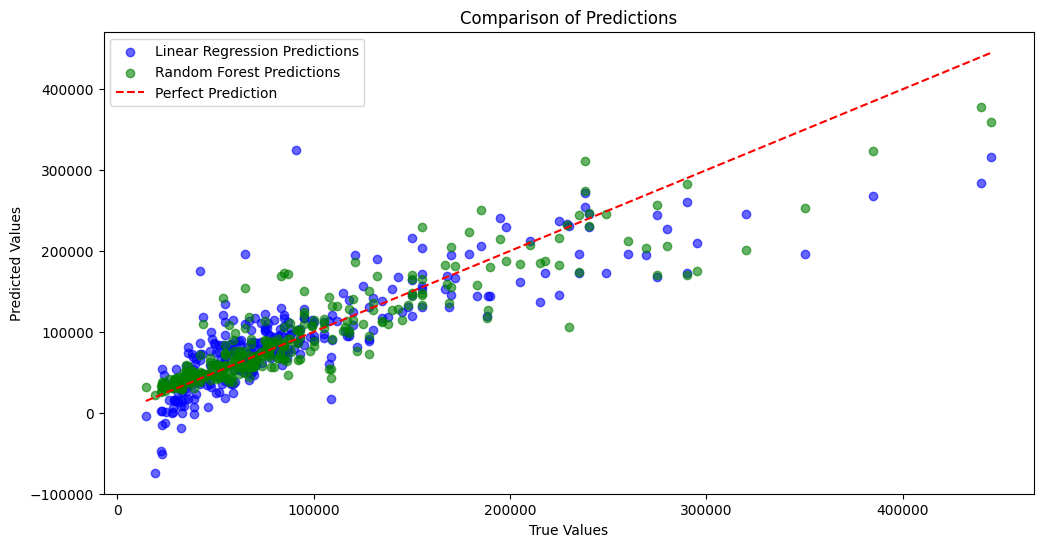

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot for comparison
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_lr, color='blue', label='Linear Regression Predictions', alpha=0.6)
plt.scatter(y_test, y_pred_rf, color='green', label='Random Forest Predictions', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Comparison of Predictions')
plt.legend()
plt.show()